In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
# from imblearn.pipeline import Pipeline as ImbPipeline
import sklearn
from sklearn.metrics import precision_score, recall_score, f1_score


In [3]:
df = pd.read_csv("Fraud.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## DATA CLEANING

In [4]:
# COnverting camel case features to snake
def camel_to_snake(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    s2 = re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1)
    return s2.replace('-', '_').lower()
df.columns = [camel_to_snake(c) for c in df.columns]
# quick peek
df.head()


,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df.shape

(6362620, 11)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   step              int64  
 1   type              object 
 2   amount            float64
 3   name_orig         object 
 4   oldbalance_org    float64
 5   newbalance_orig   float64
 6   name_dest         object 
 7   oldbalance_dest   float64
 8   newbalance_dest   float64
 9   is_fraud          int64  
 10  is_flagged_fraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:

df.isnull().sum()


step                0
type                0
amount              0
name_orig           0
oldbalance_org      0
newbalance_orig     0
name_dest           0
oldbalance_dest     0
newbalance_dest     0
is_fraud            0
is_flagged_fraud    0
dtype: int64

In [8]:
df.describe

<bound method NDFrame.describe of          step      type      amount    name_orig  oldbalance_org  \
0           1   PAYMENT     9839.64  C1231006815       170136.00   
1           1   PAYMENT     1864.28  C1666544295        21249.00   
2           1  TRANSFER      181.00  C1305486145          181.00   
3           1  CASH_OUT      181.00   C840083671          181.00   
4           1   PAYMENT    11668.14  C2048537720        41554.00   
...       ...       ...         ...          ...             ...   
6362615   743  CASH_OUT   339682.13   C786484425       339682.13   
6362616   743  TRANSFER  6311409.28  C1529008245      6311409.28   
6362617   743  CASH_OUT  6311409.28  C1162922333      6311409.28   
6362618   743  TRANSFER   850002.52  C1685995037       850002.52   
6362619   743  CASH_OUT   850002.52  C1280323807       850002.52   

         newbalance_orig    name_dest  oldbalance_dest  newbalance_dest  \
0              160296.36  M1979787155             0.00             0.00   

In [9]:
round((df["is_fraud"].value_counts()[1]/df.shape[0])* 100,2)

0.13

## EDA

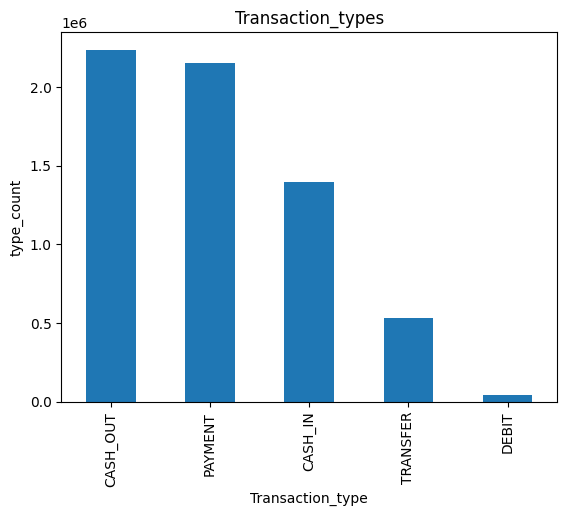

In [10]:
df["type"].value_counts().plot(kind = "bar",title = "Transaction_types")
plt.xlabel("Transaction_type")
plt.ylabel("type_count")
plt.show()


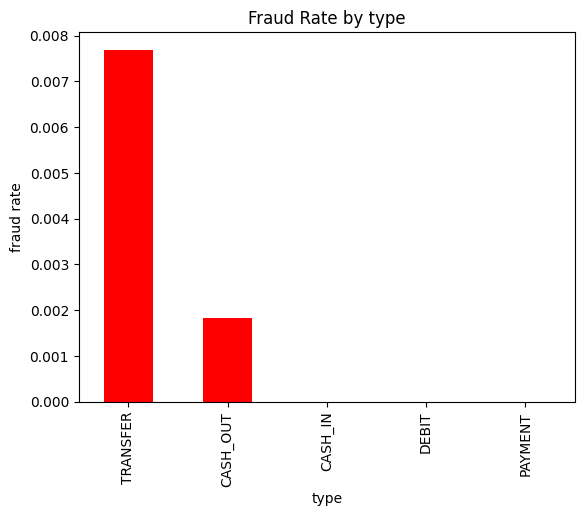

In [11]:
fraud_by_type = df.groupby("type")["is_fraud"].mean().sort_values(ascending = False)
fraud_by_type.plot(kind = "bar",title = "Fraud Rate by type", color = "red")
plt.ylabel("fraud rate")
plt.show()

In [12]:
df["amount"].describe().astype(int)

count     6362620
mean       179861
std        603858
min             0
25%         13389
50%         74871
75%        208721
max      92445516
Name: amount, dtype: int32

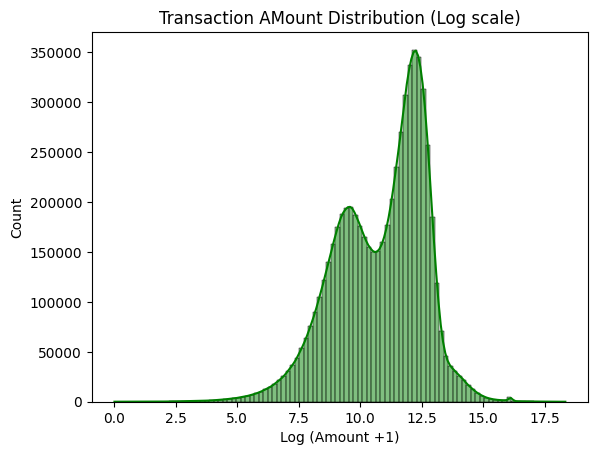

In [13]:
sns.histplot(np.log1p(df["amount"]), bins = 100, kde = True, color = "green")
plt.title("Transaction AMount Distribution (Log scale)")
plt.xlabel("Log (Amount +1)")
plt.show()

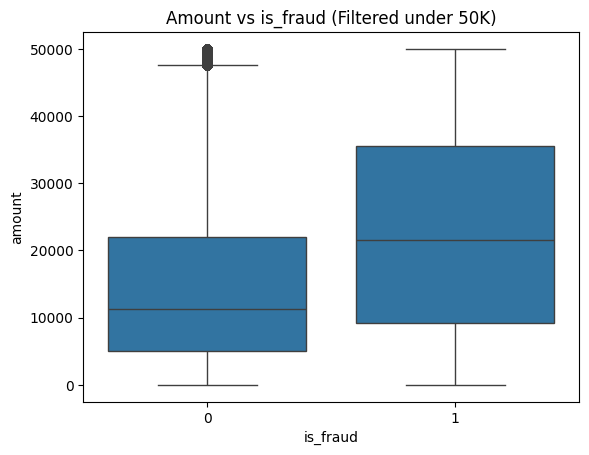

In [14]:
sns.boxplot(data = df[df["amount"]< 50000],x = "is_fraud", y = "amount")
plt.title("Amount vs is_fraud (Filtered under 50K)")
plt.show()

## FEATURE ENGINEERING

In [15]:


    # 1. Balance differences
    df['balance_diff_orig'] = df['oldbalance_org'] - df['newbalance_orig']
    df['balance_diff_dest'] = df['newbalance_dest'] - df['oldbalance_dest']
    
    # 2. Fractional amounts
    # Avoid division by zero
    df['amount_to_oldbalance'] = df['amount'] / df['oldbalance_org'].replace(0, 1)
    df['amount_to_newbalance_dest'] = df['amount'] / df['newbalance_dest'].replace(0, 1)

    
    # 3. Transaction type (categorical, one-hot encoding will be applied later)
    # Keep 'type' as is for now
    # df = pd.get_dummies(df, columns=['type'], drop_first=True)  # optional later
    
    # 4. Internal vs external account
    # In this dataset, merchant/system accounts usually start with 'M'
    df['is_internal'] = df['name_dest'].str.startswith('M').astype(int)
    
    # 5. Same account transfer
    df['is_same_account'] = (df['name_orig'] == df['name_dest']).astype(int)
    
    # 6. Time features
    df['hour'] = df['step'] % 24
    df['day_of_week'] = (df['step'] // 24) % 7  # optional
    
    # 7. Keep important original features
    important_cols = [
        'amount', 'balance_diff_orig', 'balance_diff_dest',
        'amount_to_oldbalance', 'amount_to_newbalance_dest',
        'type', 'is_flagged_fraud', 'is_internal', 'is_same_account',
        'hour', 'day_of_week'
    ]
    



df.head()


,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,balance_diff_orig,balance_diff_dest,amount_to_oldbalance,amount_to_newbalance_dest,is_internal,is_same_account,hour,day_of_week
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0,0.057834,9839.64,1,0,1,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0,0.087735,1864.28,1,0,1,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,181.00,0.0,1.000000,181.00,0,0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,181.00,-21182.0,1.000000,181.00,0,0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,11668.14,0.0,0.280795,11668.14,1,0,1,0


In [16]:
# from sklearn.preprocessing import OneHotEncoder

# ohe = OneHotEncoder(drop='first', sparse_output=False)
# type_encoded = ohe.fit_transform(df[['type']])
# type_cols = ohe.get_feature_names_out(['type'])
# type_df = pd.DataFrame(type_encoded, columns=type_cols)

# df = pd.concat([df.drop(columns=['type']), type_df], axis=1)


In [17]:
df.head()

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,balance_diff_orig,balance_diff_dest,amount_to_oldbalance,amount_to_newbalance_dest,is_internal,is_same_account,hour,day_of_week
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0,0.057834,9839.64,1,0,1,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0,0.087735,1864.28,1,0,1,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,181.00,0.0,1.000000,181.00,0,0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,181.00,-21182.0,1.000000,181.00,0,0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,11668.14,0.0,0.280795,11668.14,1,0,1,0


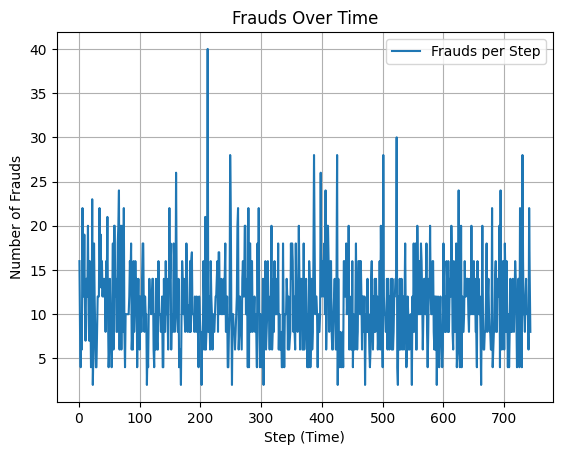

In [18]:
frauds_per_step = df[df["is_fraud"] == 1]["step"].value_counts().sort_index()


plt.plot(frauds_per_step.index, frauds_per_step.values, label="Frauds per Step")
plt.xlabel("Step (Time)")
plt.ylabel("Number of Frauds")
plt.title("Frauds Over Time")
plt.grid(True)
plt.legend()
plt.show()


In [19]:
df.drop(columns = "step",inplace = True, axis = 1)

In [20]:
df.head()

,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,balance_diff_orig,balance_diff_dest,amount_to_oldbalance,amount_to_newbalance_dest,is_internal,is_same_account,hour,day_of_week
0,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0,0.057834,9839.64,1,0,1,0
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0,0.087735,1864.28,1,0,1,0
2,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,181.00,0.0,1.000000,181.00,0,0,1,0
3,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,181.00,-21182.0,1.000000,181.00,0,0,1,0
4,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,11668.14,0.0,0.280795,11668.14,1,0,1,0


In [21]:
top_senders =df["name_orig"].value_counts().head(10)

In [22]:
top_senders

name_orig
C1902386530    3
C363736674     3
C545315117     3
C724452879     3
C1784010646    3
C1677795071    3
C1462946854    3
C1999539787    3
C2098525306    3
C400299098     3
Name: count, dtype: int64

In [23]:
top_receivers =df["name_dest"].value_counts().head(10)

In [24]:
top_receivers

name_dest
C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
C1590550415    101
C451111351      99
C1789550256     99
C1360767589     98
C1023714065     97
Name: count, dtype: int64

In [25]:
fraud_users = df[df["is_fraud"] == 1]["name_orig"].value_counts().head(10)

In [26]:
fraud_users

name_orig
C1305486145    1
C755286039     1
C973279667     1
C258213312     1
C1640703547    1
C1127265876    1
C317779855     1
C1064034527    1
C1141104763    1
C1966863341    1
Name: count, dtype: int64

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 18 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   type                       object 
 1   amount                     float64
 2   name_orig                  object 
 3   oldbalance_org             float64
 4   newbalance_orig            float64
 5   name_dest                  object 
 6   oldbalance_dest            float64
 7   newbalance_dest            float64
 8   is_fraud                   int64  
 9   is_flagged_fraud           int64  
 10  balance_diff_orig          float64
 11  balance_diff_dest          float64
 12  amount_to_oldbalance       float64
 13  amount_to_newbalance_dest  float64
 14  is_internal                int32  
 15  is_same_account            int32  
 16  hour                       int64  
 17  day_of_week                int64  
dtypes: float64(9), int32(2), int64(4), object(3)
memory usage: 825.2+ MB


In [28]:
fraud_types = df[df["type"].isin(["TRANSFER","CASH_OUT"])]

In [29]:
fraud_types["type"].value_counts()

type
CASH_OUT    2237500
TRANSFER     532909
Name: count, dtype: int64

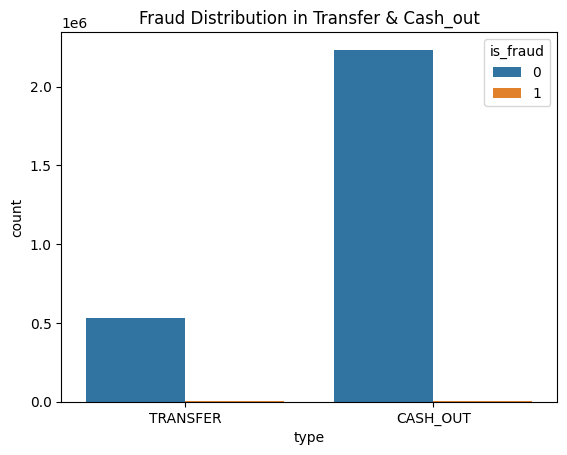

In [30]:
sns.countplot(data =fraud_types, x= "type", hue="is_fraud" )
plt.title("Fraud Distribution in Transfer & Cash_out")
plt.show()

In [31]:
df.columns

Index(['type', 'amount', 'name_orig', 'oldbalance_org', 'newbalance_orig',
       'name_dest', 'oldbalance_dest', 'newbalance_dest', 'is_fraud',
       'is_flagged_fraud', 'balance_diff_orig', 'balance_diff_dest',
       'amount_to_oldbalance', 'amount_to_newbalance_dest', 'is_internal',
       'is_same_account', 'hour', 'day_of_week'],
      dtype='object')

### Correlation

In [32]:
# Include only numeric features for correlation
numeric_cols = [
    'amount', 'balance_diff_orig', 'balance_diff_dest',
    'amount_to_oldbalance', 'amount_to_newbalance_dest',
    'is_flagged_fraud', 'is_internal', 'is_same_account',
    'hour', 'day_of_week'
]

# Add the target column
df_corr = df.copy()
df_corr['is_fraud'] = df['is_fraud']

# Compute correlation matrix
corr = df_corr[numeric_cols + ['is_fraud']].corr()

# View correlation with target
corr_with_target = corr['is_fraud'].sort_values(ascending=False)
print(corr_with_target)


is_fraud                     1.000000
balance_diff_orig            0.362472
amount_to_newbalance_dest    0.297038
amount                       0.076688
is_flagged_fraud             0.044109
balance_diff_dest            0.027028
day_of_week                  0.004946
amount_to_oldbalance        -0.004916
is_internal                 -0.025697
hour                        -0.031403
is_same_account                   NaN
Name: is_fraud, dtype: float64


In [33]:
corr

,amount,balance_diff_orig,balance_diff_dest,amount_to_oldbalance,amount_to_newbalance_dest,is_flagged_fraud,is_internal,is_same_account,hour,day_of_week,is_fraud
amount,1.000000,0.102337,0.845964,0.817085,0.100091,0.012295,-0.197444,NaN,-0.029676,0.034018,0.076688
balance_diff_orig,0.102337,1.000000,0.169292,0.018734,0.232739,0.000230,0.134576,NaN,-0.002880,-0.002591,0.362472
balance_diff_dest,0.845964,0.169292,1.000000,0.690193,-0.032137,-0.000242,-0.109286,NaN,-0.023730,0.023423,0.027028
amount_to_oldbalance,0.817085,0.018734,0.690193,1.000000,-0.021072,-0.000220,-0.092648,NaN,-0.004091,0.028828,-0.004916
amount_to_newbalance_dest,0.100091,0.232739,-0.032137,-0.021072,1.000000,0.087922,-0.008734,NaN,-0.028487,0.005418,0.297038
is_flagged_fraud,0.012295,0.000230,-0.000242,-0.000220,0.087922,1.000000,-0.001133,NaN,-0.000462,0.000380,0.044109
is_internal,-0.197444,0.134576,-0.109286,-0.092648,-0.008734,-0.001133,1.000000,NaN,0.011111,-0.001142,-0.025697
is_same_account,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hour,-0.029676,-0.002880,-0.023730,-0.004091,-0.028487,-0.000462,0.011111,NaN,1.000000,0.007042,-0.031403
day_of_week,0.034018,-0.002591,0.023423,0.028828,0.005418,0.000380,-0.001142,NaN,0.007042,1.000000,0.004946


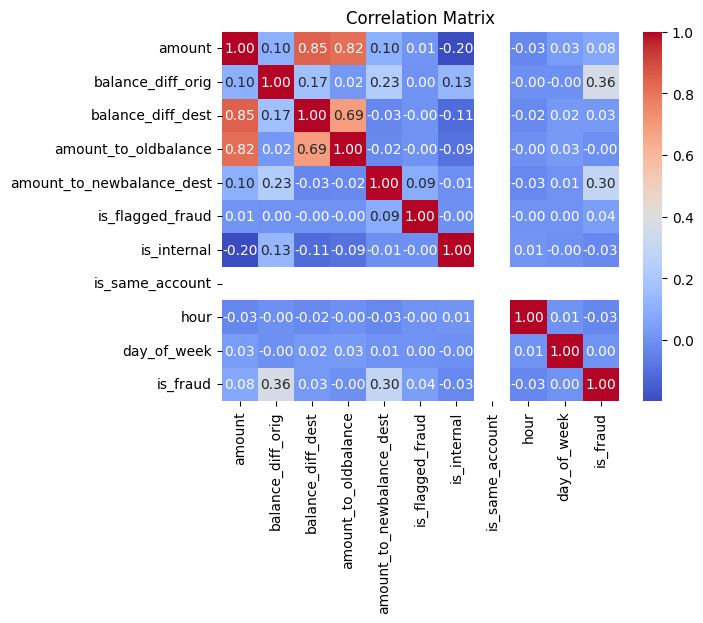

In [34]:
sns.heatmap(corr, annot= True, cmap = "coolwarm", fmt = ".2f")
plt.title("Correlation Matrix")
plt.show()

In [35]:
zero_after_transfer = df[
 (df["oldbalance_org"] > 0)&
 (df["newbalance_orig"] == 0) &
 (df["type"].isin(["TRANSFER","CASH_OUT"])) 
]

In [36]:
len(zero_after_transfer)

1188074

In [37]:
zero_after_transfer.head()

,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,balance_diff_orig,balance_diff_dest,amount_to_oldbalance,amount_to_newbalance_dest,is_internal,is_same_account,hour,day_of_week
2,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,181.0,0.00,1.000000,181.000000,0,0,1,0
3,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,181.0,-21182.00,1.000000,181.000000,0,0,1,0
15,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,15325.0,46430.44,14.951644,4.448042,0,0,1,0
19,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,705.0,-22425.00,305.404681,215310.300000,0,0,1,0
24,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,10835.0,2712905.89,28.766580,0.114625,0,0,1,0


In [38]:
df["is_fraud"].value_counts().sum

<bound method Series.sum of is_fraud
0    6354407
1       8213
Name: count, dtype: int64>

In [39]:
df.sample(5)

,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,balance_diff_orig,balance_diff_dest,amount_to_oldbalance,amount_to_newbalance_dest,is_internal,is_same_account,hour,day_of_week
2444570,PAYMENT,14501.20,C1857221983,0.00,0.0,M1394956059,0.0,0.00,0,0,0.00,0.00,14501.200000,14501.200000,1,0,11,1
1192510,CASH_IN,157576.72,C162981494,4035134.69,4192711.4,C109490548,1220010.6,1062433.89,0,0,-157576.71,-157576.71,0.039051,0.148317,0,0,12,5
3008683,CASH_OUT,321950.32,C1658600984,11055.00,0.0,C1973678319,0.0,321950.32,0,0,11055.00,321950.32,29.122598,1.000000,0,0,16,2
6027282,PAYMENT,5176.82,C994236991,0.00,0.0,M1967902263,0.0,0.00,0,0,0.00,0.00,5176.820000,5176.820000,1,0,13,5
4691980,CASH_OUT,51289.48,C852495320,0.00,0.0,C762707196,2809279.5,2860568.97,0,0,0.00,51289.47,51289.480000,0.017930,0,0,19,6


In [40]:
df_model = df.drop(['is_same_account', 'name_orig', 'name_dest', 'hour', 'day_of_week'], axis=1)


In [41]:
df_model.head()

,type,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,balance_diff_orig,balance_diff_dest,amount_to_oldbalance,amount_to_newbalance_dest,is_internal
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0,9839.64,0.0,0.057834,9839.64,1
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0,1864.28,0.0,0.087735,1864.28,1
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0,181.00,0.0,1.000000,181.00,0
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0,181.00,-21182.0,1.000000,181.00,0
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0,11668.14,0.0,0.280795,11668.14,1


In [42]:
categorical_col = ["type"]
numerical_col = [
    "amount",
    "balance_diff_orig",
    "amount_to_newbalance_dest",
    "is_flagged_fraud",
    "is_internal"
]



### Multicollinearity check using VIF

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 
# from sklearn.ensemble import RandomForestClassifier


In [44]:
# Multicollinearity check using VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_num = df[numerical_col]  # numeric features only
vif_data = pd.DataFrame()
vif_data["feature"] = X_num.columns
vif_data["VIF"] = [variance_inflation_factor(X_num.values, i)
                   for i in range(len(X_num.columns))]
print(vif_data)


                     feature       VIF
0                     amount  1.020880
1          balance_diff_orig  1.044909
2  amount_to_newbalance_dest  1.077648
3           is_flagged_fraud  1.008027
4                is_internal  1.007520


## Dataset spliting

In [45]:
# y = df_model["is_fraud"]
# X = df_model.drop("is_fraud",axis = 1)

In [46]:
# X_train,X_test,y_train,y_test = train_test_split(X,y, test_size =0.3, stratify = y,random_state= 42)

In [47]:
# Train test split
from sklearn.model_selection import train_test_split

X = df_model.drop("is_fraud", axis=1)
y = df_model["is_fraud"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [48]:
y.value_counts()

is_fraud
0    6354407
1       8213
Name: count, dtype: int64

<Axes: ylabel='count'>

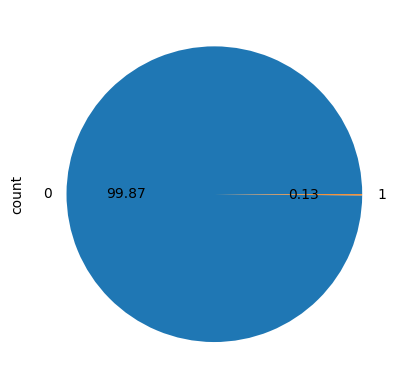

In [49]:
y.value_counts().plot.pie(autopct = '%.2f')

In [50]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler



preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_col),              #standardscaling on numerical column
        ('cat', OneHotEncoder(drop='first'), categorical_col)  #one hot encoding on categorical column
    ]
)


In [51]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve

# 1. Select only high-impact features
features = [
    'balance_diff_orig', 'amount_to_newbalance_dest', 'amount',
    'type', 'is_flagged_fraud', 'is_internal'
]


X = df_model[features]
y = df_model['is_fraud']

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Build pipeline

pipeline = Pipeline([
    ('prep', preprocessor),  # ColumnTransformer handles numeric + categorical
    ('smote', SMOTE(random_state=42)),  # oversample minority class
    ('clf', XGBClassifier(
        scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train),
        max_depth=6,
        n_estimators=300,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    ))
])
pipeline.fit(X_train, y_train)

# 5. Predict probabilities
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# 6. Threshold tuning for better precision
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)


# Align precision & recall with thresholds
precision = precision[:-1]
recall = recall[:-1]

# Compute F1 for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Get threshold that gives maximum F1
best_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[best_idx]

# Apply threshold
y_pred_opt = (y_pred_proba >= optimal_threshold).astype(int)

# Evaluate
print(f"Optimal Threshold = {optimal_threshold:.2f}")
print(classification_report(y_test, y_pred_opt))


Optimal Threshold = 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.96      0.72      0.82      1643

    accuracy                           1.00   1272524
   macro avg       0.98      0.86      0.91   1272524
weighted avg       1.00      1.00      1.00   1272524



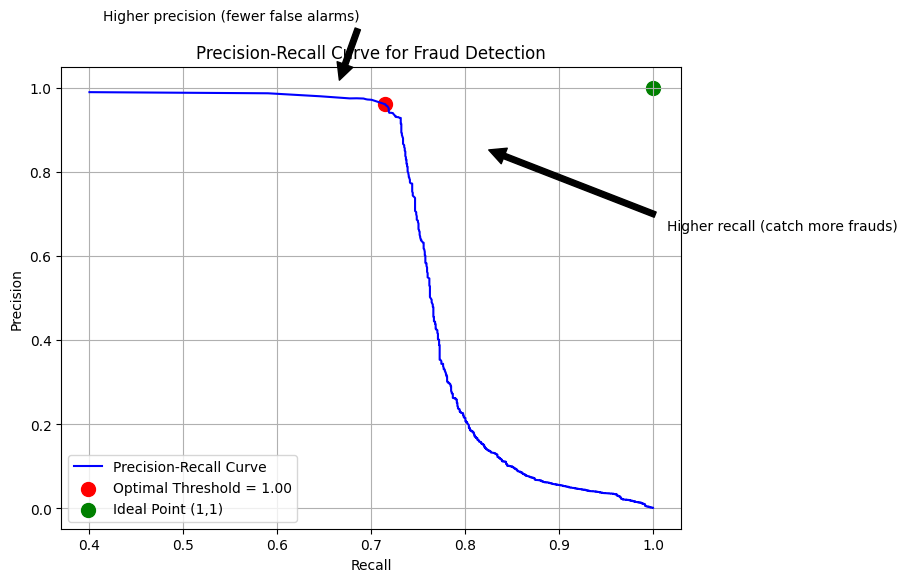

In [53]:
# Plot PR curve
plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='b', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Fraud Detection')

# Mark optimal threshold (red point)
plt.scatter(recall[best_idx], precision[best_idx],
            color='r', s=100, label=f'Optimal Threshold = {optimal_threshold:.2f}')

# Mark ideal point (top-right corner)
plt.scatter(1, 1, color='g', s=100, label='Ideal Point (1,1)')

# Add arrows for trade-off
plt.annotate('Higher recall (catch more frauds)', xy=(recall[best_idx]+0.1, precision[best_idx]-0.1),
             xytext=(recall[best_idx]+0.3, precision[best_idx]-0.3),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=10)

plt.annotate('Higher precision (fewer false alarms)', xy=(recall[best_idx]-0.05, precision[best_idx]+0.05),
             xytext=(recall[best_idx]-0.3, precision[best_idx]+0.2),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=10)

plt.legend()
plt.grid(True)
plt.show()

## ROC CURVE & AUC INTERPRETATION

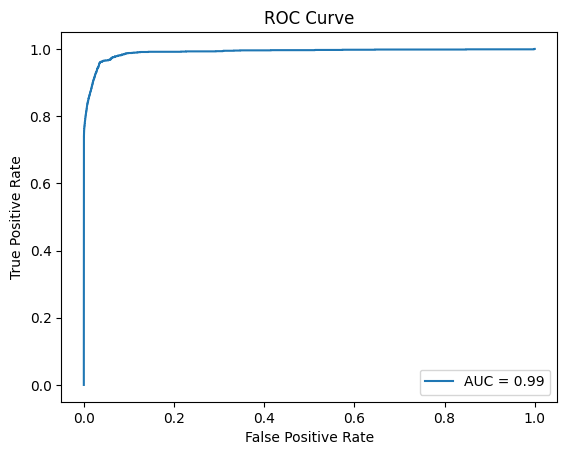

In [54]:
from sklearn.metrics import roc_curve, roc_auc_score

y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='AUC = %.2f' % roc_auc_score(y_test, y_pred_proba))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

##### The ROC curve for our logistic regression fraud detection model shows an AUC score of 0.99, indicating excellent performance in distinguishing between fraudulent and legitimate transactions. The model achieves a high true positive rate while maintaining a very low false positive rate across most thresholds. This performance demonstrates the model's robustness and suitability for real-time fraud detection, where catching fraudulent activity while minimizing false alarms is critical.

## Feature Importance

In [59]:
import pandas as pd

# Get feature names after preprocessing
feature_names = (
    pipeline.named_steps['prep'].transformers_[0][2] +  # numerical columns
    list(pipeline.named_steps['prep'].transformers_[1][1].get_feature_names_out(categorical_col))
)

# Extract booster from XGBClassifier
xgb_clf = pipeline.named_steps['clf']
booster = xgb_clf.get_booster()

# Get feature importance by GAIN
importance_dict = booster.get_score(importance_type='gain')

# Map importance_dict keys (f0, f1, ...) back to feature names
importance = pd.DataFrame({
    'feature': [feature_names[int(k[1:])] for k in importance_dict.keys()],
    'coefficient': list(importance_dict.values())
}).sort_values(by='coefficient', ascending=False)

importance.head(15)


,feature,coefficient
4,is_internal,788607.062500
1,balance_diff_orig,24491.949219
6,type_DEBIT,17015.654297
0,amount,14056.662109
5,type_CASH_OUT,7312.455078
2,amount_to_newbalance_dest,5090.340820
7,type_TRANSFER,5078.436035
3,is_flagged_fraud,4855.894531


In [58]:

# Get feature names after preprocessing
feature_names = (
    pipeline.named_steps['prep'].transformers_[0][2] +  # numerical columns
    list(pipeline.named_steps['prep'].transformers_[1][1].get_feature_names_out(categorical_col))
)

# Extract feature importance from XGBoost
xgb_clf = pipeline.named_steps['clf']
importances = xgb_clf.feature_importances_

# Create DataFrame like your LogisticRegression style
importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': importances
}).sort_values(by='coefficient', ascending=False)

importance.head(15)

,feature,coefficient
4,is_internal,0.910097
1,balance_diff_orig,0.028265
6,type_DEBIT,0.019637
0,amount,0.016222
5,type_CASH_OUT,0.008439
2,amount_to_newbalance_dest,0.005875
8,type_TRANSFER,0.005861
3,is_flagged_fraud,0.005604
7,type_PAYMENT,0.000000


##### Feature importance analysis from our logistic regression model shows that the most significant predictors of fraud are transaction types and account balances. Transfers and cash-out transactions have the highest positive coefficients, indicating a strong correlation with fraudulent activity. Conversely, payment transactions and normal post-transaction balances are associated with legitimate activity. These insights align with typical fraud patterns, where funds are often moved quickly through transfers or cash withdrawals from high-balance accounts.

In [ ]:
y_pred = pipeline.predict(X_test)

#### Performance of the model

In [ ]:
confusion_matrix(y_test, y_pred_opt)

In [ ]:
pipeline.score(X_test, y_test)

In [ ]:
import joblib
joblib.dump(pipeline, "fraud_detection_pipeline.pkl")

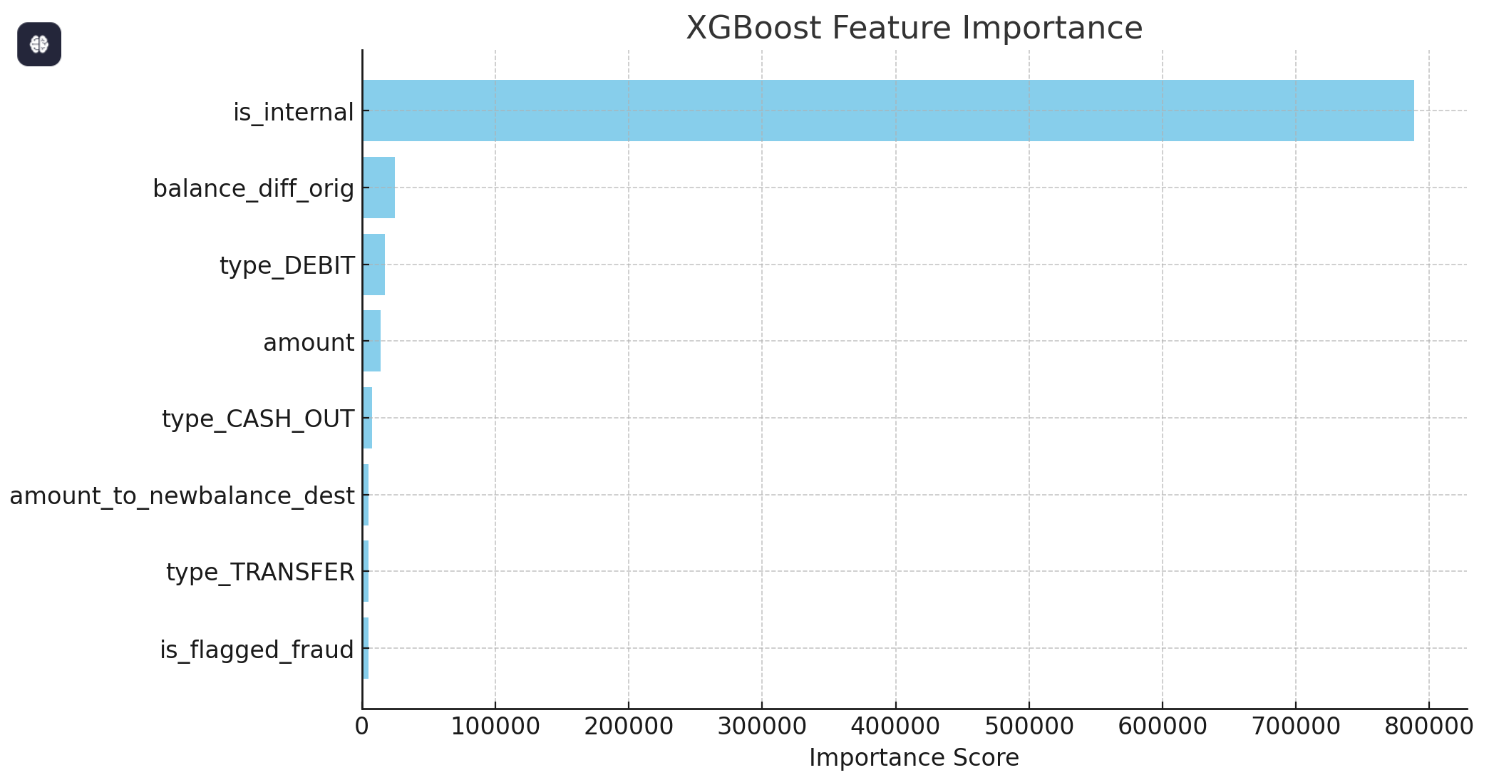